In [1]:
import sys
sys.path.append("../../")

In [2]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}
SEED = 44
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
# define problem
# problem = BraninCurrin(negate=True).to(**tkwargs)
problem = GMM(negate=True).to(**tkwargs)
problem.ref_point = torch.tensor([0., 0.], **tkwargs)

## Problem

The approximated pareto set and pareto front is shown in the following figure.

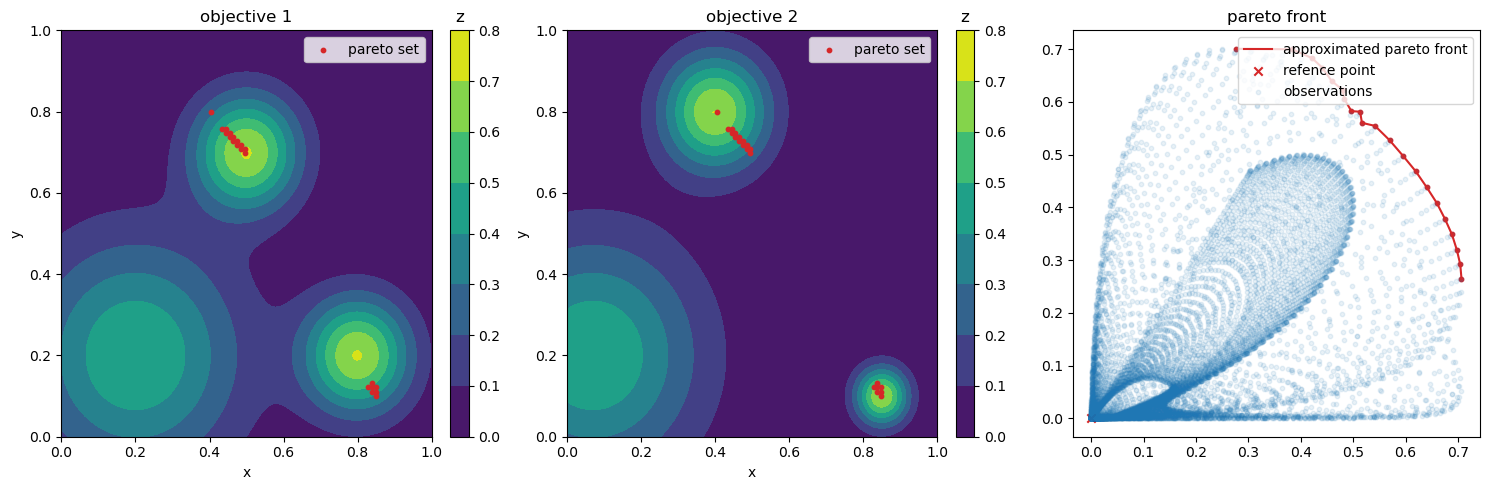

In [4]:
from plot_utils import plot_objective

plot_objective(problem, num_samples=100)

In [5]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [6]:
init_x, init_y = generate_initial_data(problem, n=6)

## Generate data

In [7]:
from optimizers.mbore.mbore_mdre_ei import MBORE_MDRE_EI
from optimizers.mbore.mbore_mdre_eimo import MBORE_MDRE_EIMO
from optimizers.mbore.mbore_mdre_ei_aux import MBORE_MDRE_EI_AUX
from optimizers.mbore.mbore_mdre_ei_aux_rf import MBORE_MDRE_EI_AUX_RF

In [8]:
def plot_input_space(xx, yy, x_obs, preds, fig, ax, title=None):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        preds.reshape(xx.shape),
    )
    ax.scatter(*x_obs.t(), alpha=0.3, s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(title)
    clb.ax.set_title('z')


def plot_pareto_space(y_obs, pareto, l, u_nbd, ax, title='pareto'):
    ax.scatter(*y_obs[~pareto].t(), s=10, alpha=0.3)
    ax.scatter(*l.t(), s=10, color='tab:red', label="pareto")
    ax.plot(*l.t(), color='tab:red')
    # ax.scatter(*u_nbd.t(), s=10, label="non dominated", color='tab:purple')
    ax.scatter(*problem.ref_point.t(), s=10, color='k', label="ref point")

    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_title(title)
    ax.legend()


def plot_pareto_box(tau, boxes, ax):
    ax.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
    pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
    pc.set_array(torch.arange(0, len(boxes)))
    ax.add_collection(pc)
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    ax.axvspan(x_lim[0], tau[0], alpha=0.1, color='tab:gray')
    ax.axhspan(y_lim[0], tau[1], alpha=0.1, color='tab:gray')
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)

In [9]:
x_obs = init_x
y_obs = init_y

num_obj = problem.num_objectives
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], 100
    ),
    np.linspace(
        *problem.bounds.t()[1], 100
    ),
)
x_cands = np.vstack((xx.flatten(), yy.flatten())).T
x_cands = torch.from_numpy(x_cands).to(**tkwargs)
y_cands = problem(x_cands).reshape(100, 100, num_obj)
xx_obj, yy_obj = y_cands[:, :, 0], y_cands[:, :, 1]

In [10]:
# optimizer = MBORE_MDRE_EI_AUX_RF(
#     problem=problem, 
# )
# for n in range(30):
#     print(f"Iteration {n}")

#     pareto = is_non_dominated(y_obs)
#     bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
#     nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
#     u, l = bd.hypercell_bounds
#     u_nbd, _ = nbd.hypercell_bounds

#     boxes = [Rectangle(
#         l_point.cpu(),
#         *(u_point - l_point).cpu(),
#     ) for l_point, u_point in zip(l, u)]

#     new_x = optimizer.observe_and_suggest(x_obs, y_obs, gamma=1/4)
#     new_y = problem(new_x)

#     preds_p = torch.empty(0, **tkwargs).numpy()
#     preds_q = torch.empty(0, **tkwargs).numpy()
#     preds_m = torch.empty(0, **tkwargs).numpy()
#     preds = torch.empty(0, **tkwargs).numpy()
#     i = 0

#     acf_mdre = optimizer.clf.predict_proba(x_cands.numpy())
#     pred_logits = np.log(np.clip(acf_mdre, a_min=1e-4, a_max=None))
#     dr_mdre = 1 - acf_mdre[:, 1]
#     # dr_mdre = pred_logits[:, 0] + pred_logits[:, 2] - pred_logits[:, 1]
    
#     preds = np.concatenate([preds, dr_mdre])
#     preds_p = np.concatenate([preds_p, acf_mdre[:, 0]])
#     preds_q = np.concatenate([preds_q, acf_mdre[:, 1]])
#     preds_m = np.concatenate([preds_m, acf_mdre[:, 2]])

#     # plot aggregated results
#     fig = plt.figure(figsize=(25, 5))

#     ax_p = plt.subplot2grid((1, 5), (0, 0))
#     plot_input_space(xx, yy, x_obs, preds_p, fig, ax_p, title="p")
#     ax_p.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
#     ax_q = plt.subplot2grid((1, 5), (0, 1))
#     plot_input_space(xx, yy, x_obs, preds_q, fig, ax_q, title="q")
#     ax_q.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
#     ax_m = plt.subplot2grid((1, 5), (0, 2))
#     plot_input_space(xx, yy, x_obs, preds_m, fig, ax_m, title="m")
#     ax_m.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
#     ax_m.scatter(*optimizer.x_m.T, marker='x', color='tab:green', label='candidates')

#     ax_agg = plt.subplot2grid((1, 5), (0, 3))
#     plot_input_space(xx, yy, x_obs, preds, fig, ax_agg, title="aggregated results")
#     ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')

#     ax_agg_p = plt.subplot2grid((1,  5), (0, 4))
#     plot_pareto_space(y_obs, pareto, l, u_nbd, ax_agg_p, title='pareto')
#     ax_agg_p.scatter(*new_y.t(), marker='x', color='tab:orange', label='candidates')

#     probs = optimizer.auxi_clf.predict_proba(x_cands)
#     _, ax = plt.subplots(1, 1, figsize=(3, 3))
#     plot_input_space(xx, yy, x_obs, probs[:, 1], fig, ax, title="p")

#     plt.tight_layout()
#     plt.show()
#     x_obs = torch.cat([x_obs, new_x])
#     y_obs = torch.cat([y_obs, new_y])

2024-04-24 17:07:24,264 | optimizers.mbore.mbore_mdre_ei_aux


Iteration 0


100%|██████████| 500/500 [00:02<00:00, 224.73it/s]
2024-04-24 17:07:28,006 | Model fitting takes 3.72s
2024-04-24 17:07:28,012 | Optimizing the acquisition function takes 0.00s


tensor(4.4442, dtype=torch.float64)
tensor(0.9883, dtype=torch.float64)


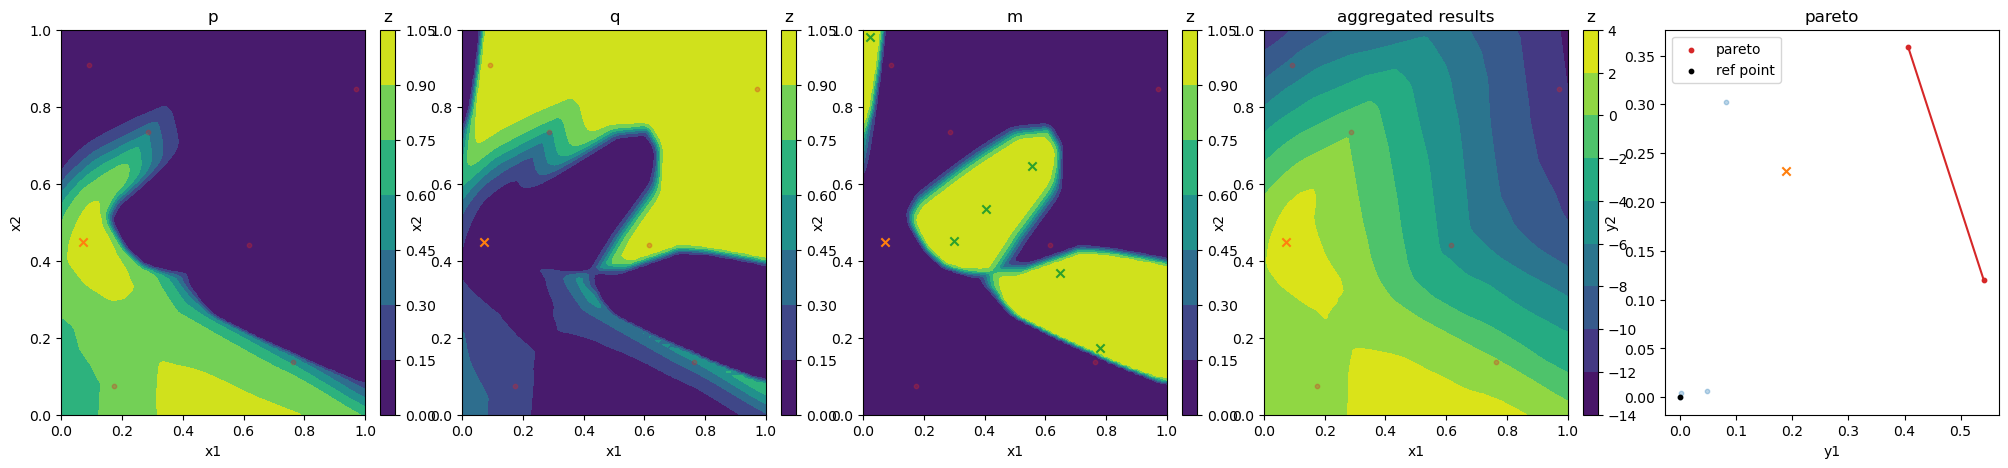

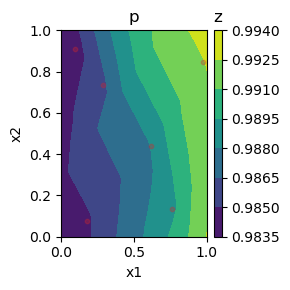

Iteration 1


100%|██████████| 500/500 [00:02<00:00, 216.96it/s]
2024-04-24 17:07:32,421 | Model fitting takes 3.59s
2024-04-24 17:07:32,426 | Optimizing the acquisition function takes 0.00s


tensor(3.9403, dtype=torch.float64)
tensor(0.9806, dtype=torch.float64)


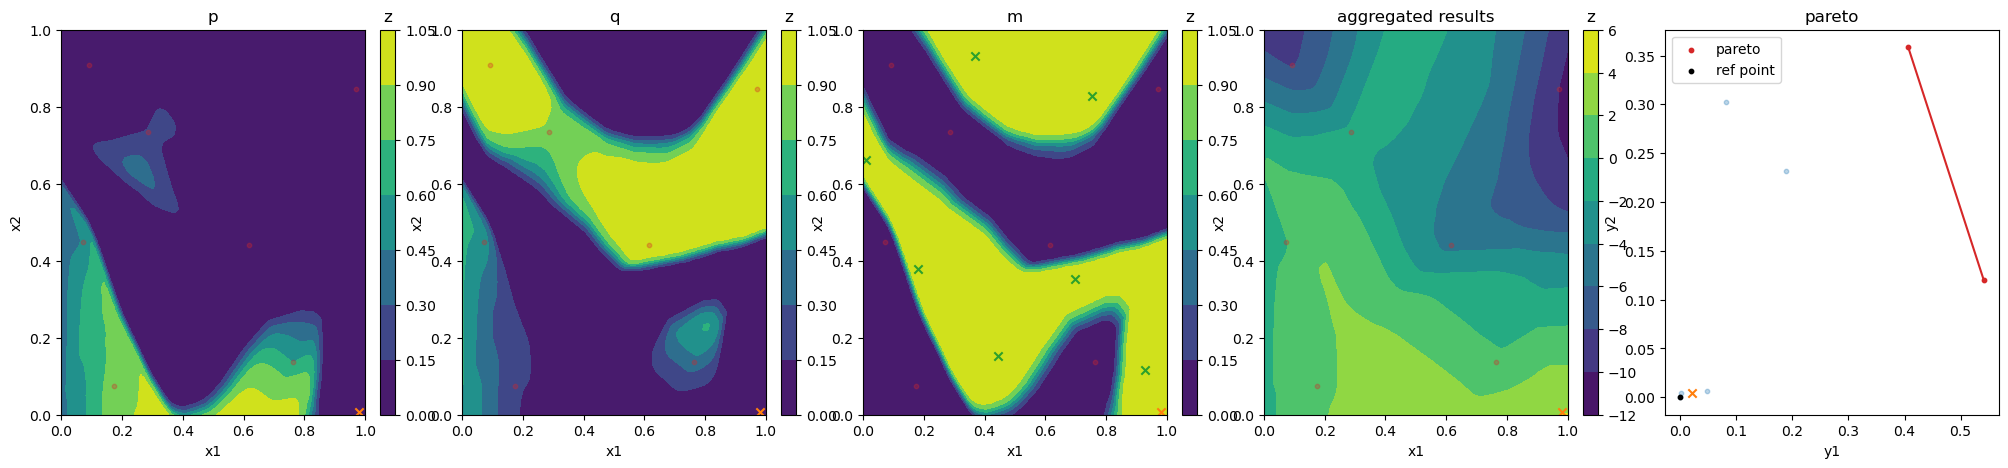

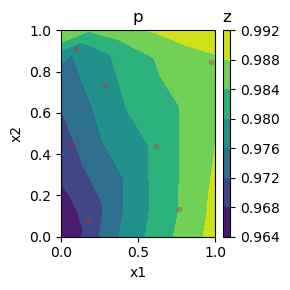

Iteration 2


100%|██████████| 500/500 [00:02<00:00, 225.01it/s]
2024-04-24 17:07:37,340 | Model fitting takes 3.56s
2024-04-24 17:07:37,346 | Optimizing the acquisition function takes 0.00s


tensor(3.5912, dtype=torch.float64)
tensor(0.9724, dtype=torch.float64)


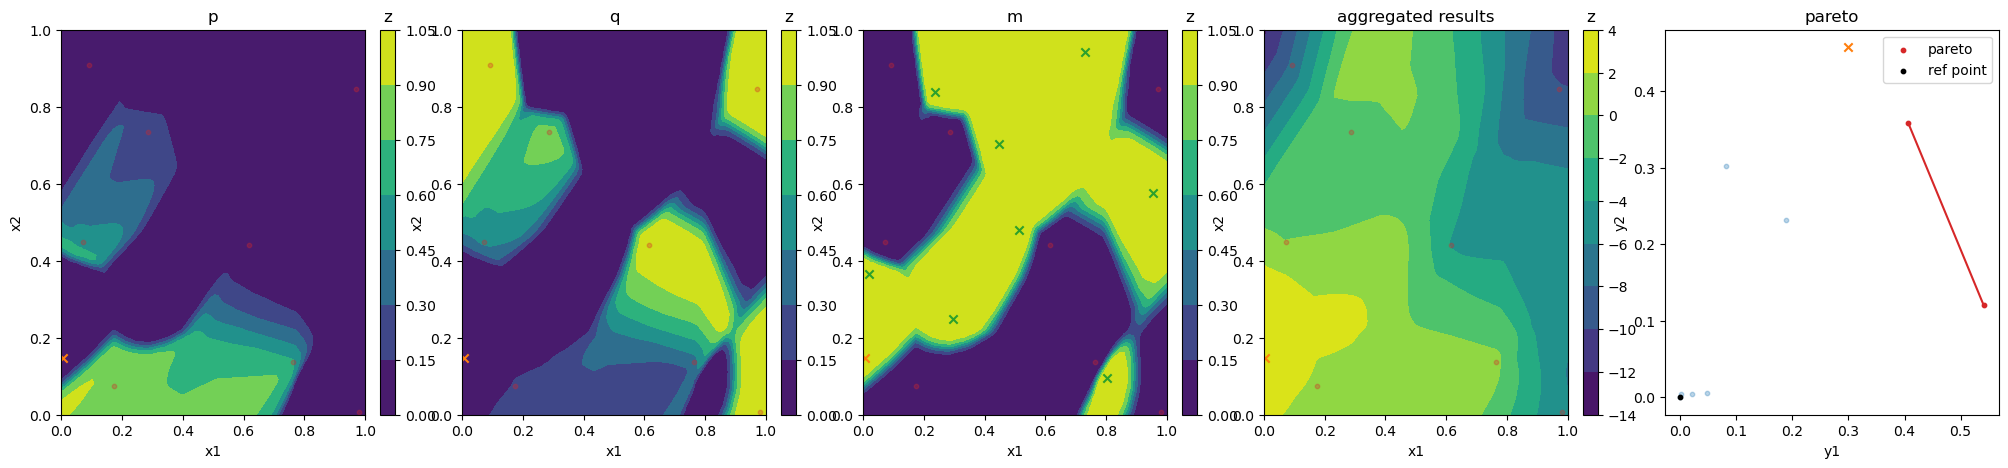

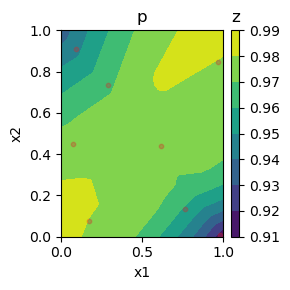

Iteration 3


100%|██████████| 500/500 [00:02<00:00, 197.98it/s]
2024-04-24 17:07:42,219 | Model fitting takes 4.01s
2024-04-24 17:07:42,224 | Optimizing the acquisition function takes 0.00s


tensor(3.8337, dtype=torch.float64)
tensor(0.9784, dtype=torch.float64)


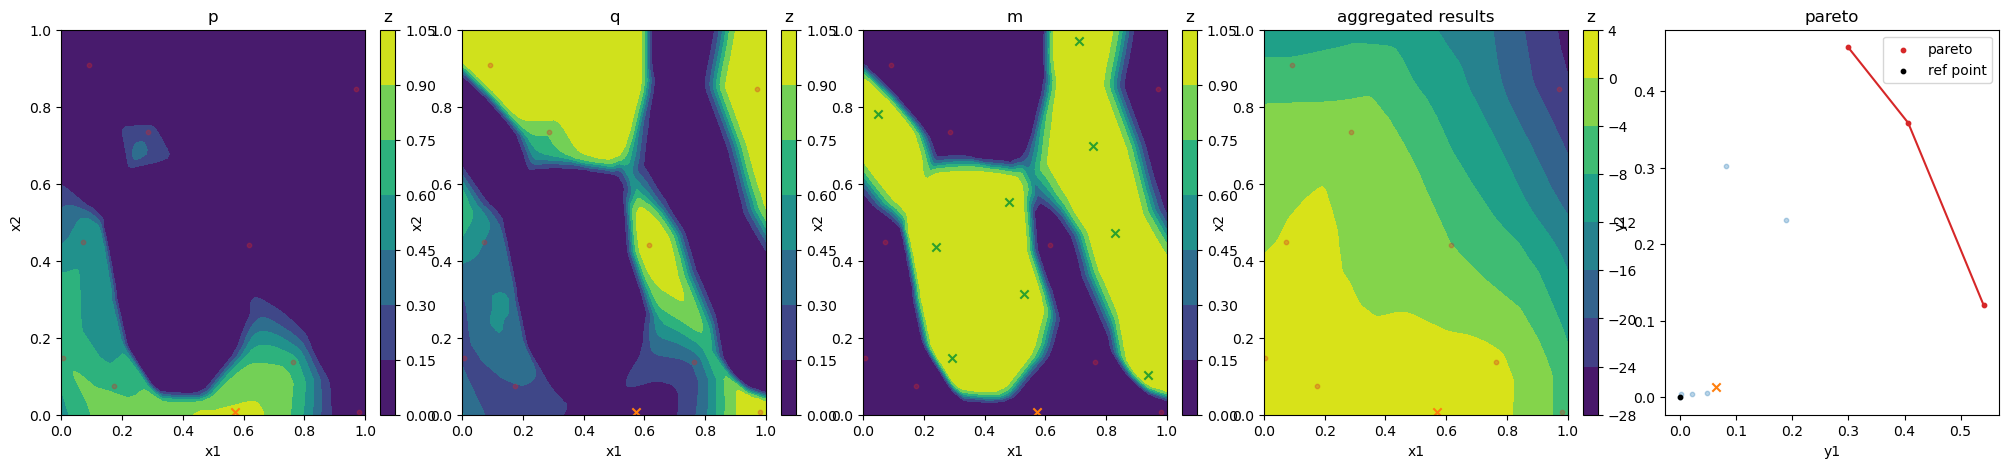

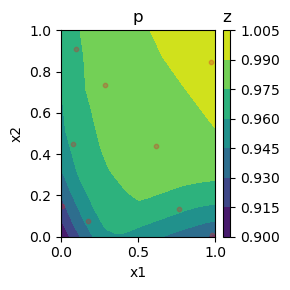

Iteration 4


100%|██████████| 500/500 [00:02<00:00, 217.43it/s]
2024-04-24 17:07:46,832 | Model fitting takes 3.76s
2024-04-24 17:07:46,837 | Optimizing the acquisition function takes 0.00s


tensor(3.4793, dtype=torch.float64)
tensor(0.9692, dtype=torch.float64)


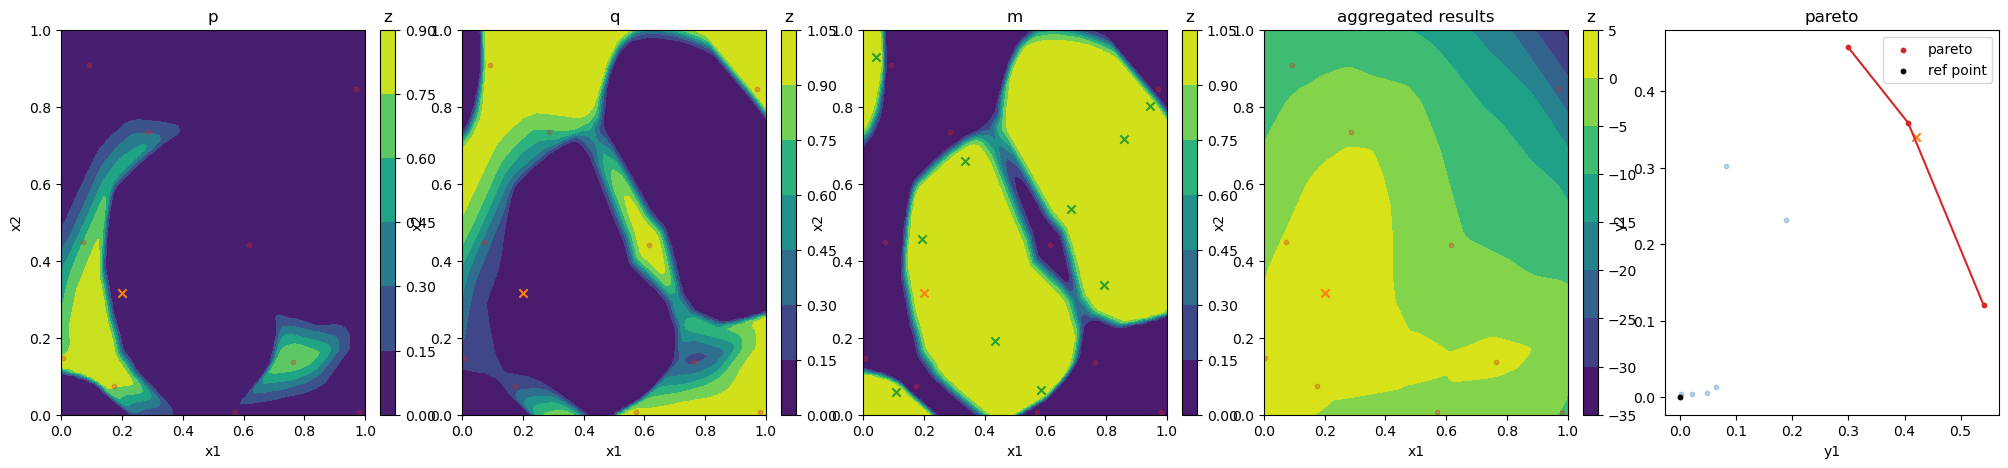

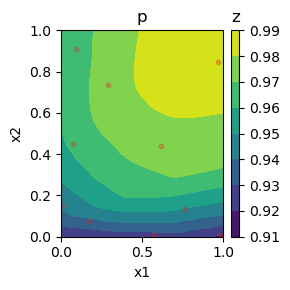

Iteration 5


100%|██████████| 500/500 [00:02<00:00, 203.11it/s]
2024-04-24 17:07:51,721 | Model fitting takes 3.92s
2024-04-24 17:07:51,725 | Optimizing the acquisition function takes 0.00s


tensor(3.4870, dtype=torch.float64)
tensor(0.9694, dtype=torch.float64)


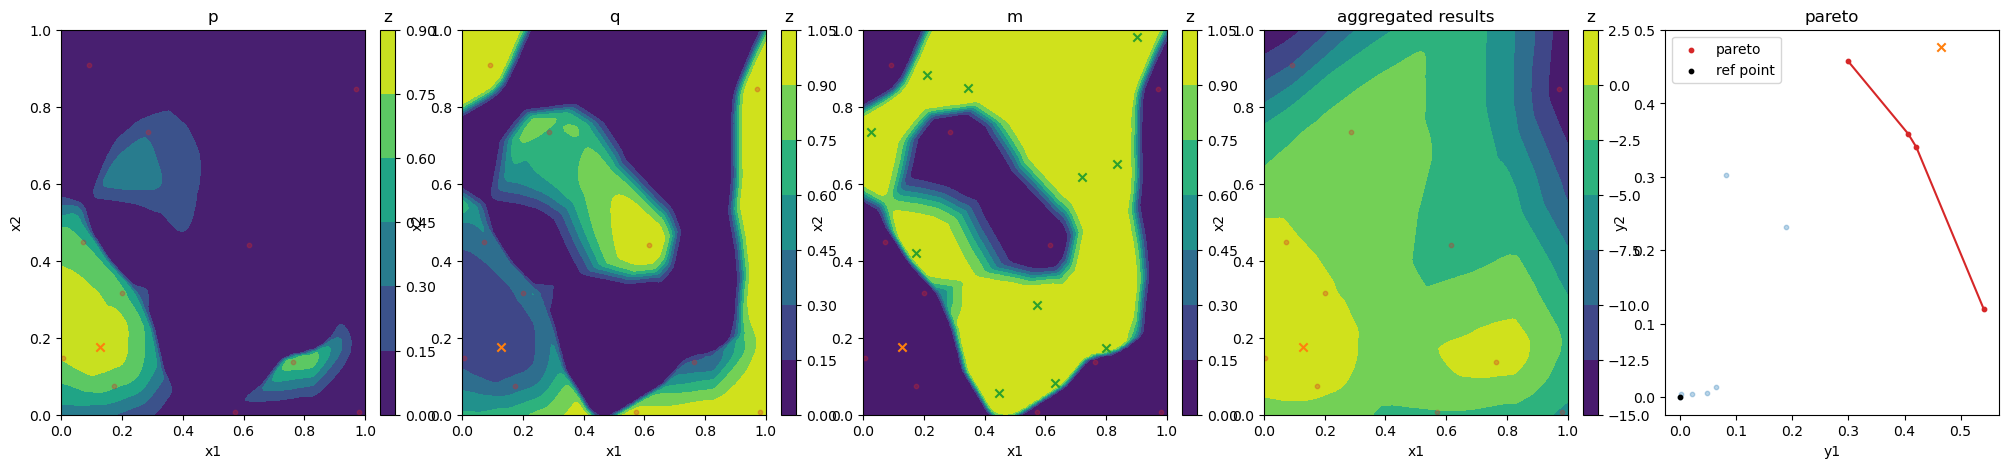

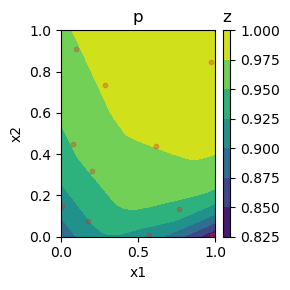

Iteration 6


100%|██████████| 500/500 [00:02<00:00, 209.27it/s]
2024-04-24 17:07:56,400 | Model fitting takes 3.78s
2024-04-24 17:07:56,405 | Optimizing the acquisition function takes 0.00s


tensor(3.4073, dtype=torch.float64)
tensor(0.9669, dtype=torch.float64)


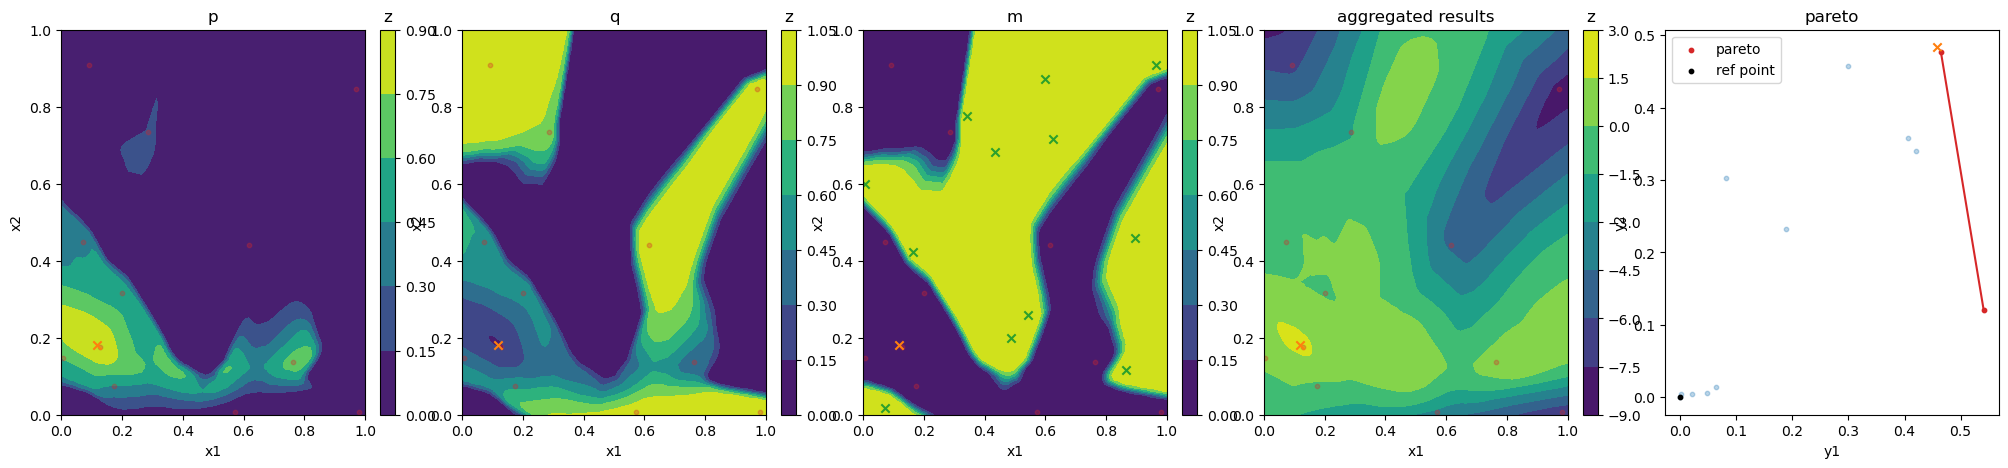

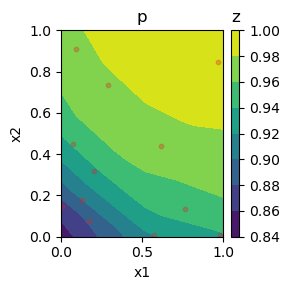

Iteration 7


100%|██████████| 500/500 [00:02<00:00, 222.87it/s]
2024-04-24 17:08:01,043 | Model fitting takes 3.60s
2024-04-24 17:08:01,048 | Optimizing the acquisition function takes 0.00s


tensor(2.9552, dtype=torch.float64)
tensor(0.9479, dtype=torch.float64)


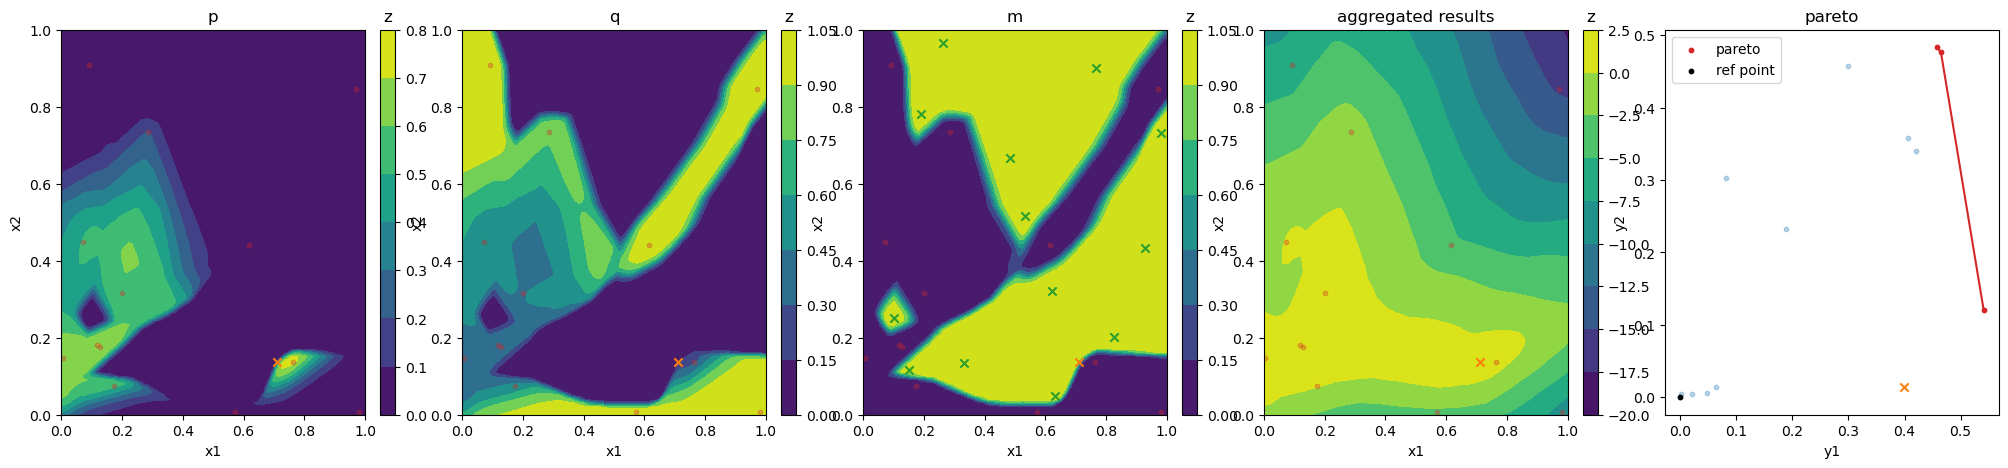

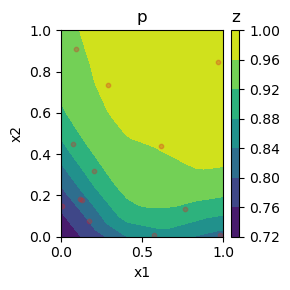

Iteration 8


100%|██████████| 500/500 [00:02<00:00, 199.24it/s]
2024-04-24 17:08:06,183 | Model fitting takes 4.10s
2024-04-24 17:08:06,187 | Optimizing the acquisition function takes 0.00s


tensor(3.1920, dtype=torch.float64)
tensor(0.9589, dtype=torch.float64)


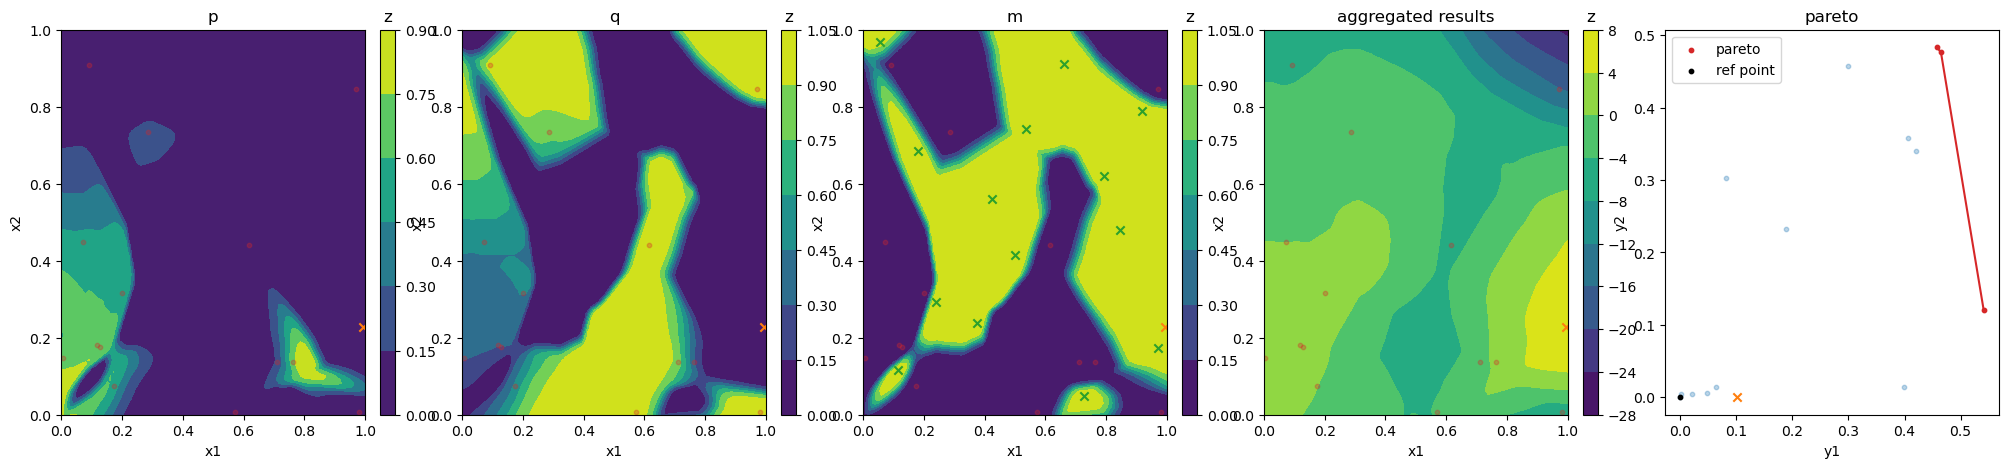

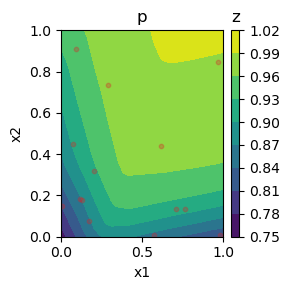

Iteration 9


100%|██████████| 500/500 [00:02<00:00, 196.60it/s]
2024-04-24 17:08:11,178 | Model fitting takes 4.14s
2024-04-24 17:08:11,183 | Optimizing the acquisition function takes 0.00s


tensor(3.1565, dtype=torch.float64)
tensor(0.9574, dtype=torch.float64)


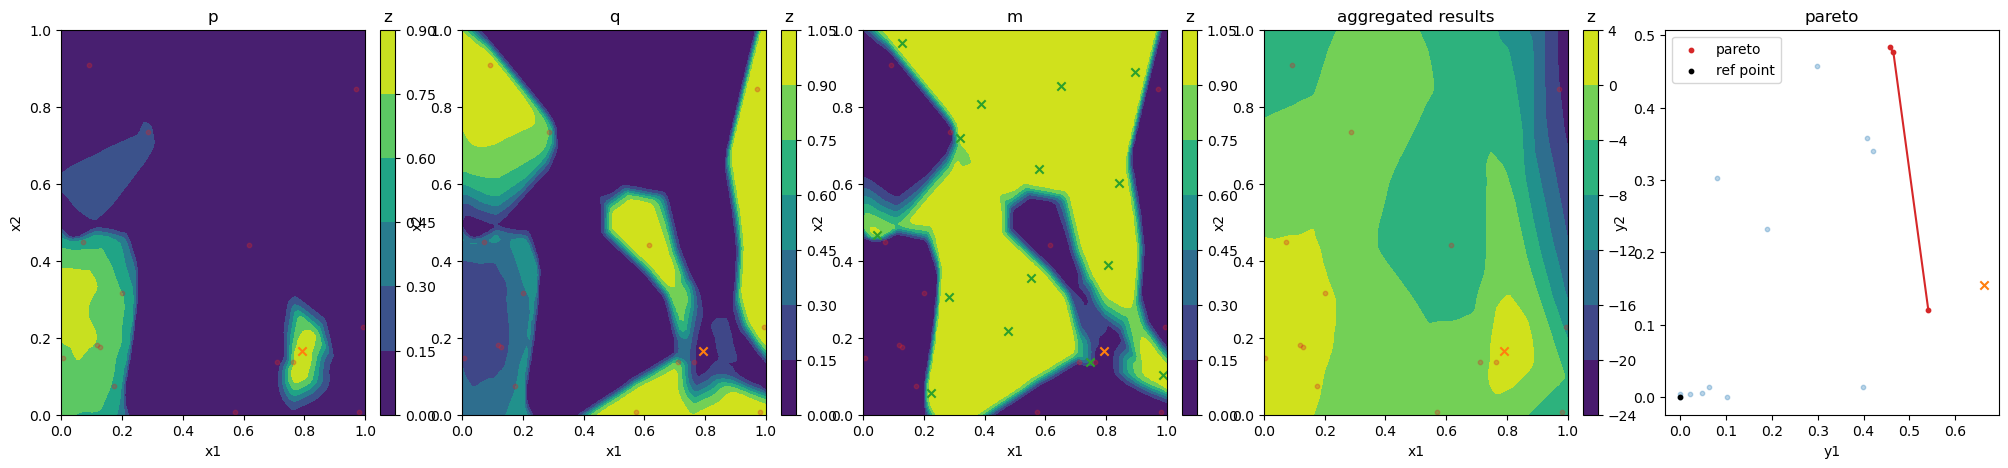

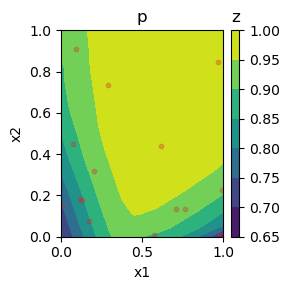

Iteration 10


100%|██████████| 500/500 [00:02<00:00, 236.91it/s]
2024-04-24 17:08:15,683 | Model fitting takes 3.67s
2024-04-24 17:08:15,688 | Optimizing the acquisition function takes 0.00s


tensor(3.3345, dtype=torch.float64)
tensor(0.9644, dtype=torch.float64)


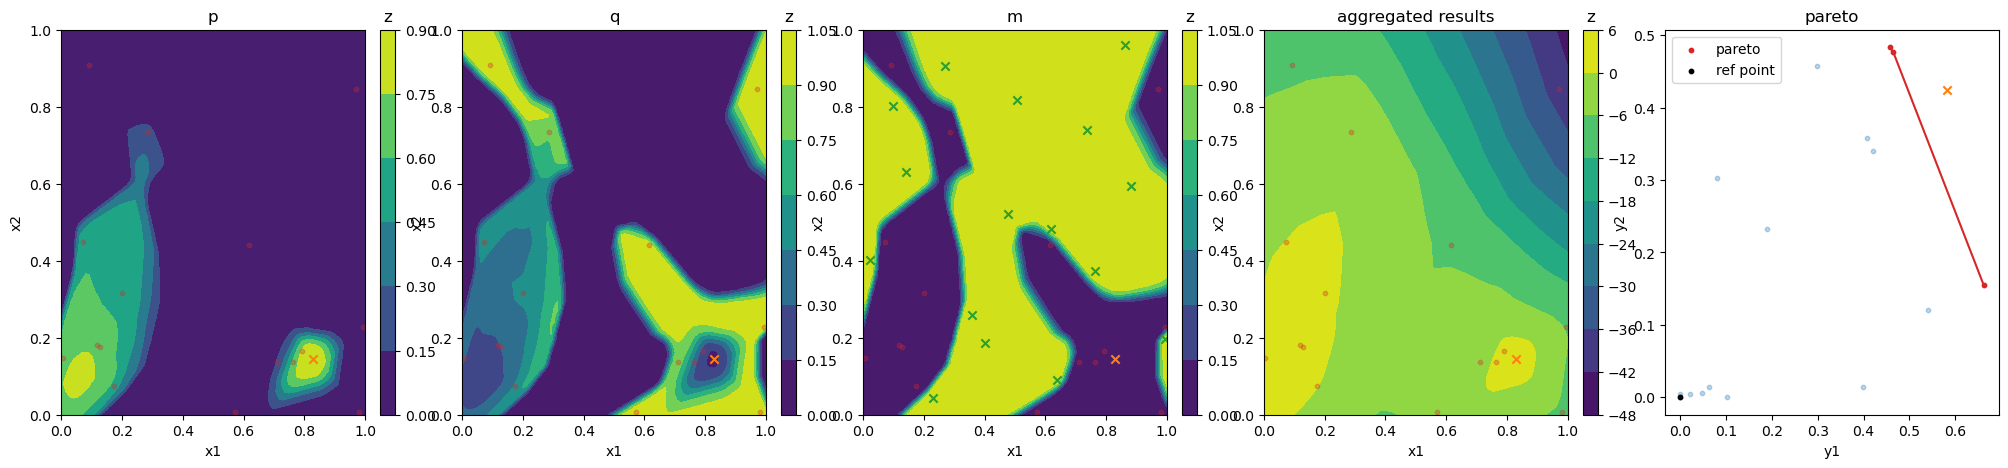

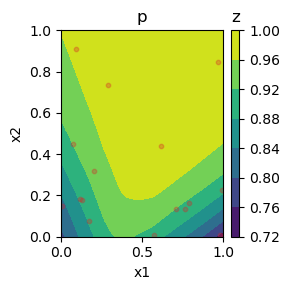

Iteration 11


100%|██████████| 500/500 [00:02<00:00, 203.66it/s]
2024-04-24 17:08:20,701 | Model fitting takes 4.00s
2024-04-24 17:08:20,706 | Optimizing the acquisition function takes 0.00s


tensor(3.1262, dtype=torch.float64)
tensor(0.9561, dtype=torch.float64)


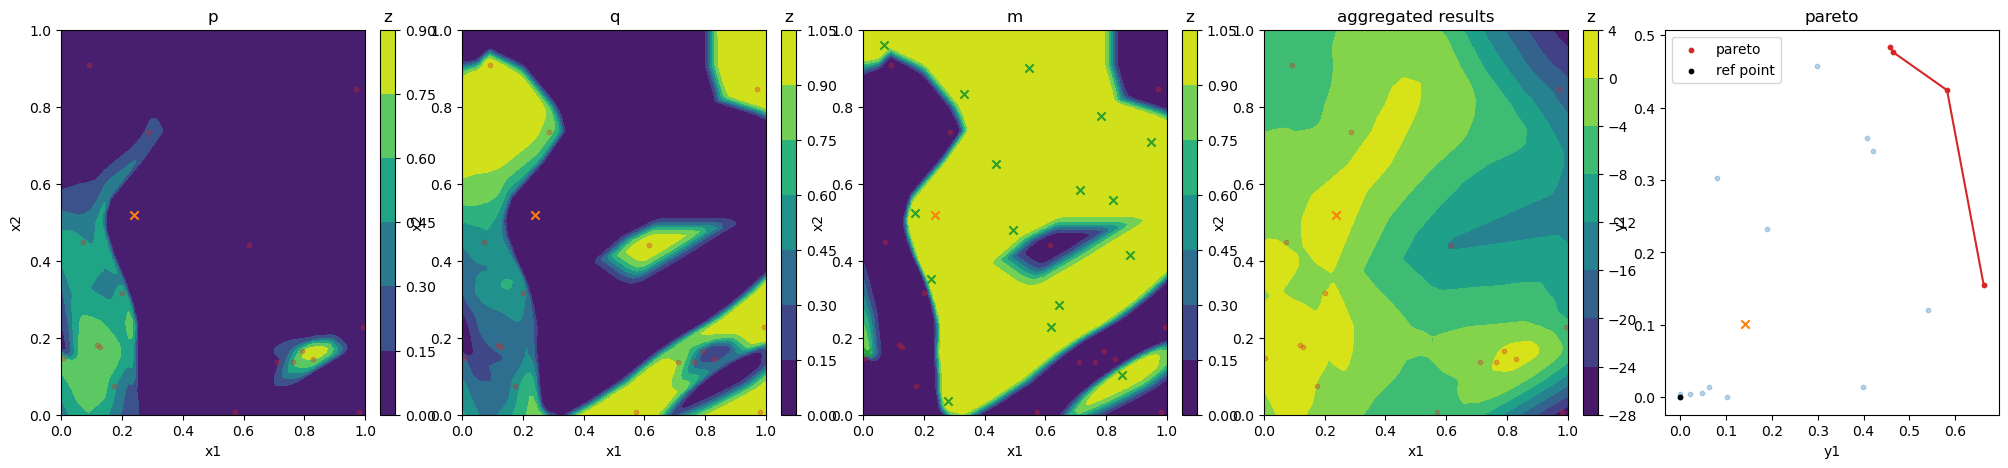

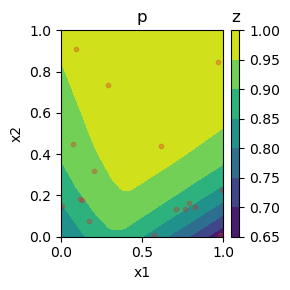

Iteration 12


100%|██████████| 500/500 [00:02<00:00, 198.73it/s]
2024-04-24 17:08:25,782 | Model fitting takes 4.22s
2024-04-24 17:08:25,786 | Optimizing the acquisition function takes 0.00s


tensor(2.9220, dtype=torch.float64)
tensor(0.9462, dtype=torch.float64)


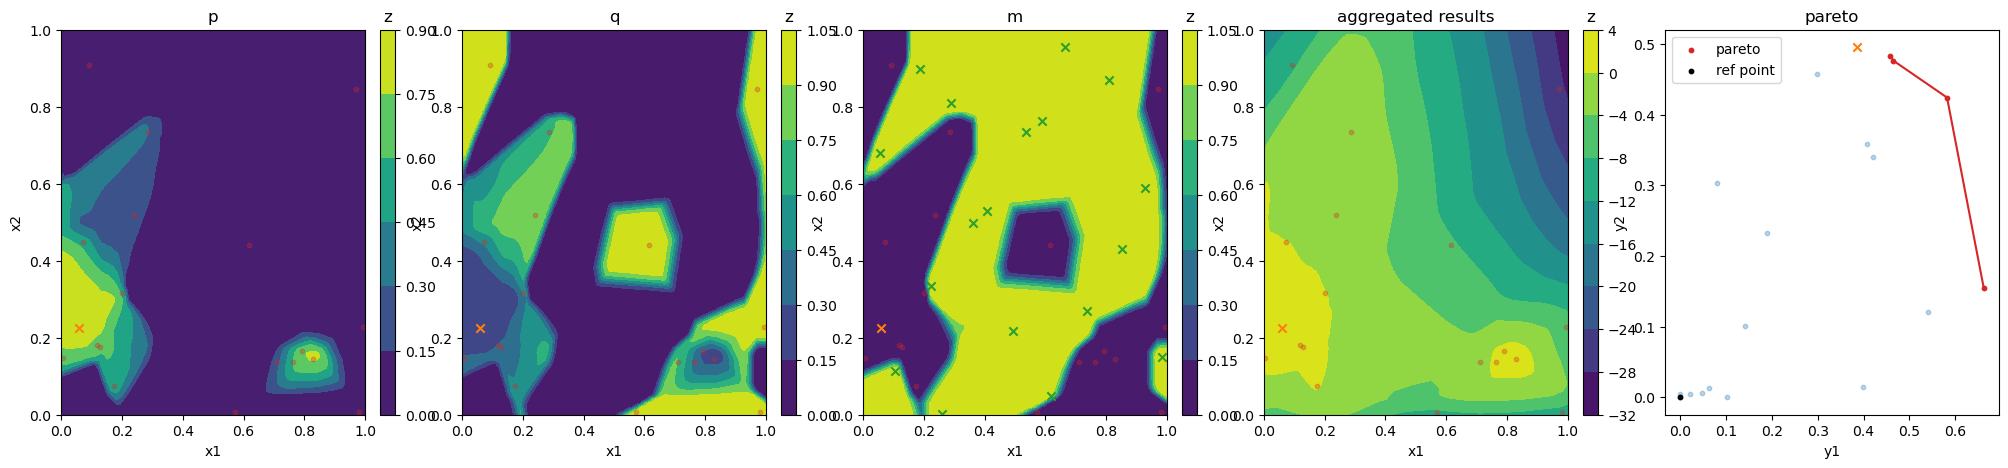

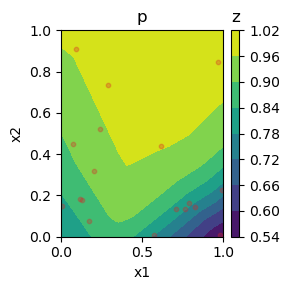

Iteration 13


100%|██████████| 500/500 [00:02<00:00, 206.63it/s]
2024-04-24 17:08:30,784 | Model fitting takes 4.06s
2024-04-24 17:08:30,788 | Optimizing the acquisition function takes 0.00s


tensor(3.1600, dtype=torch.float64)
tensor(0.9576, dtype=torch.float64)


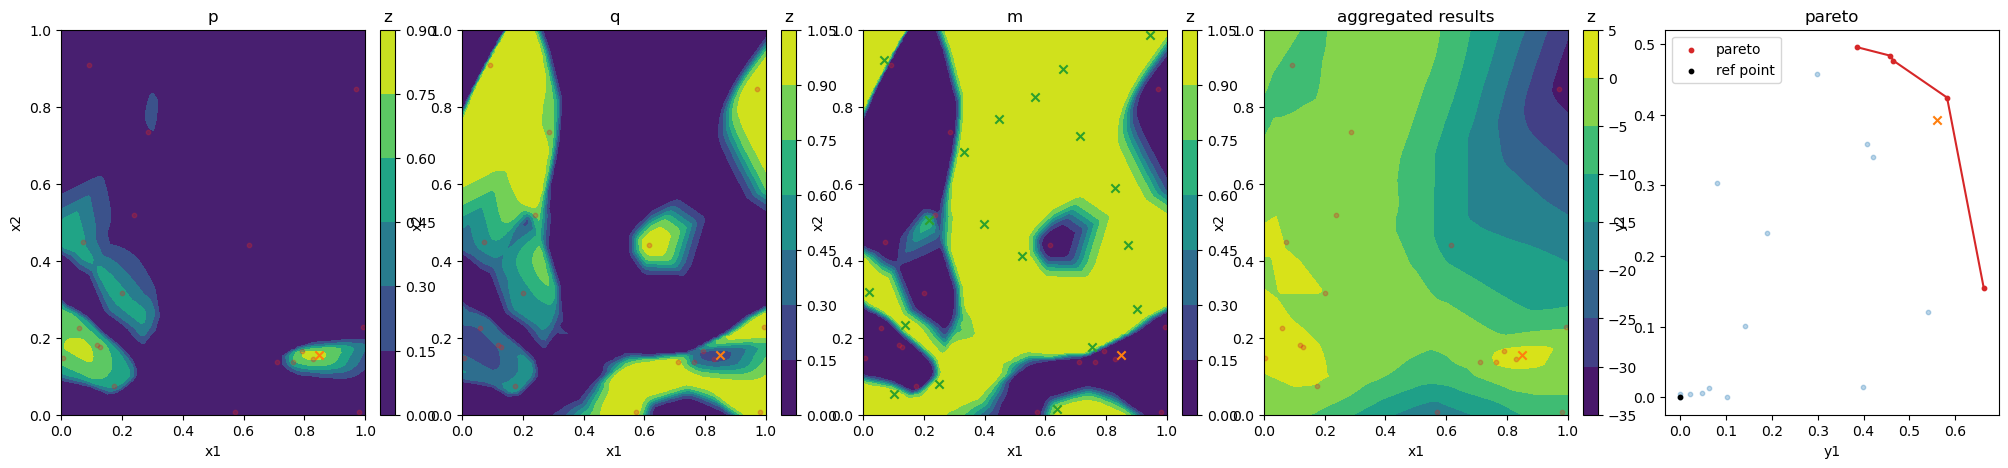

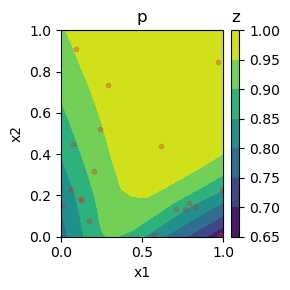

Iteration 14


100%|██████████| 500/500 [00:02<00:00, 229.82it/s]
2024-04-24 17:08:35,660 | Model fitting takes 3.93s
2024-04-24 17:08:35,665 | Optimizing the acquisition function takes 0.00s


tensor(3.5464, dtype=torch.float64)
tensor(0.9712, dtype=torch.float64)


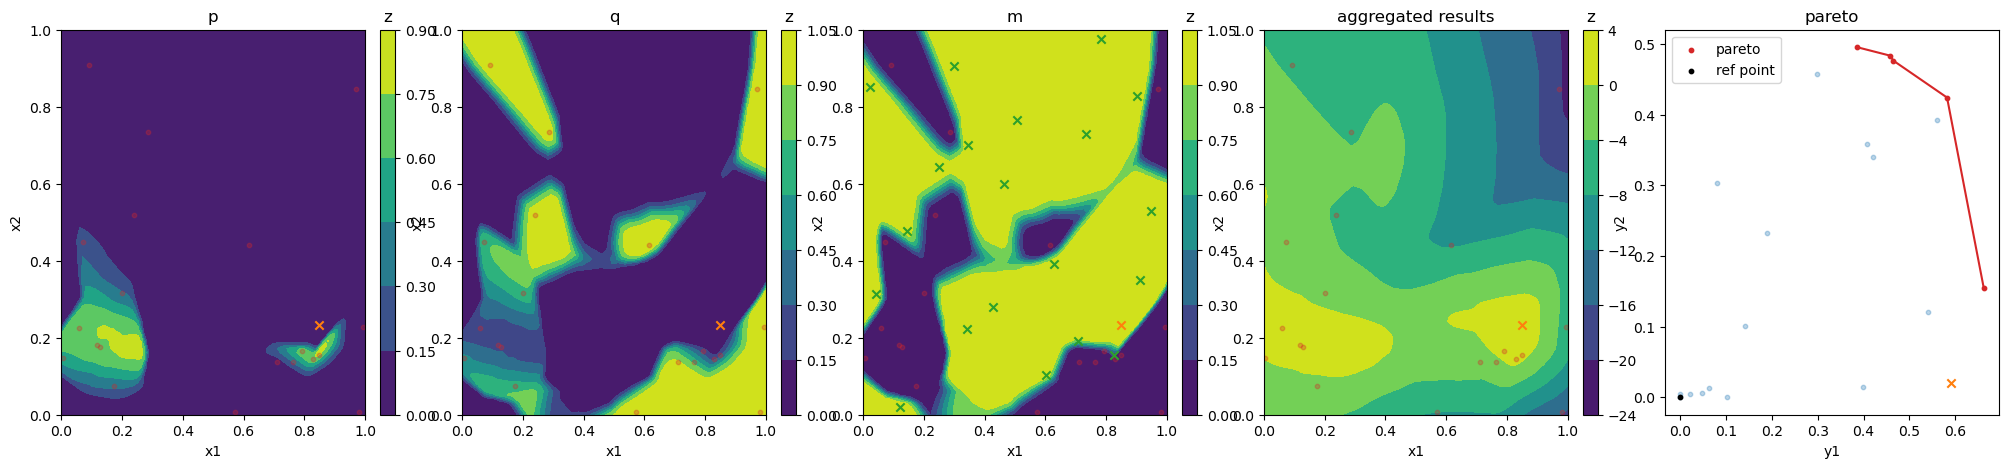

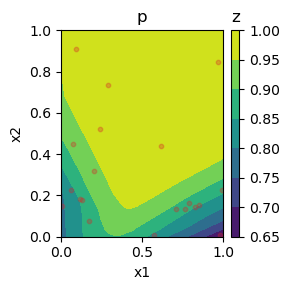

Iteration 15


100%|██████████| 500/500 [00:02<00:00, 184.28it/s]
2024-04-24 17:08:40,941 | Model fitting takes 4.44s
2024-04-24 17:08:40,946 | Optimizing the acquisition function takes 0.00s


tensor(2.7183, dtype=torch.float64)
tensor(0.9340, dtype=torch.float64)


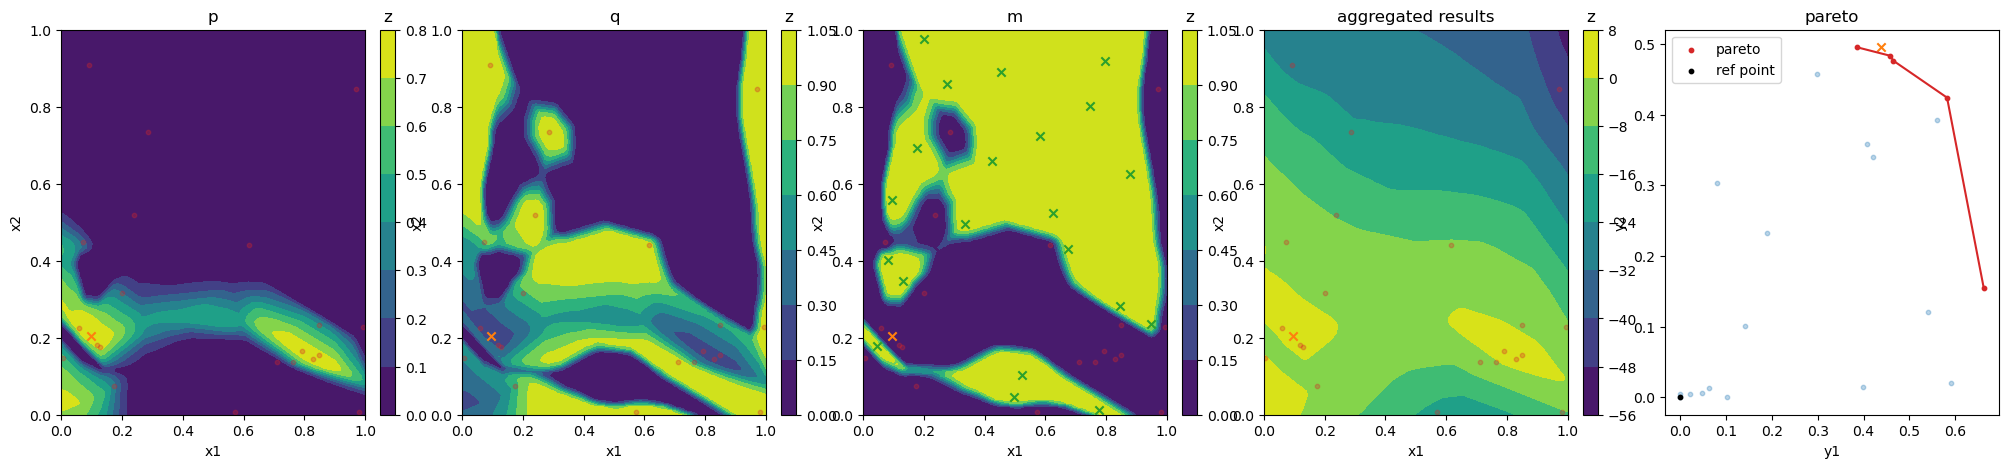

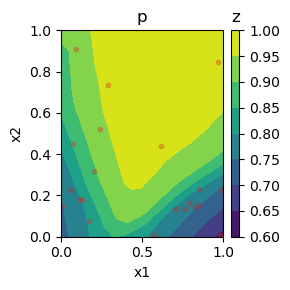

Iteration 16


100%|██████████| 500/500 [00:02<00:00, 203.31it/s]
2024-04-24 17:08:46,073 | Model fitting takes 4.28s
2024-04-24 17:08:46,079 | Optimizing the acquisition function takes 0.00s


tensor(3.1035, dtype=torch.float64)
tensor(0.9551, dtype=torch.float64)


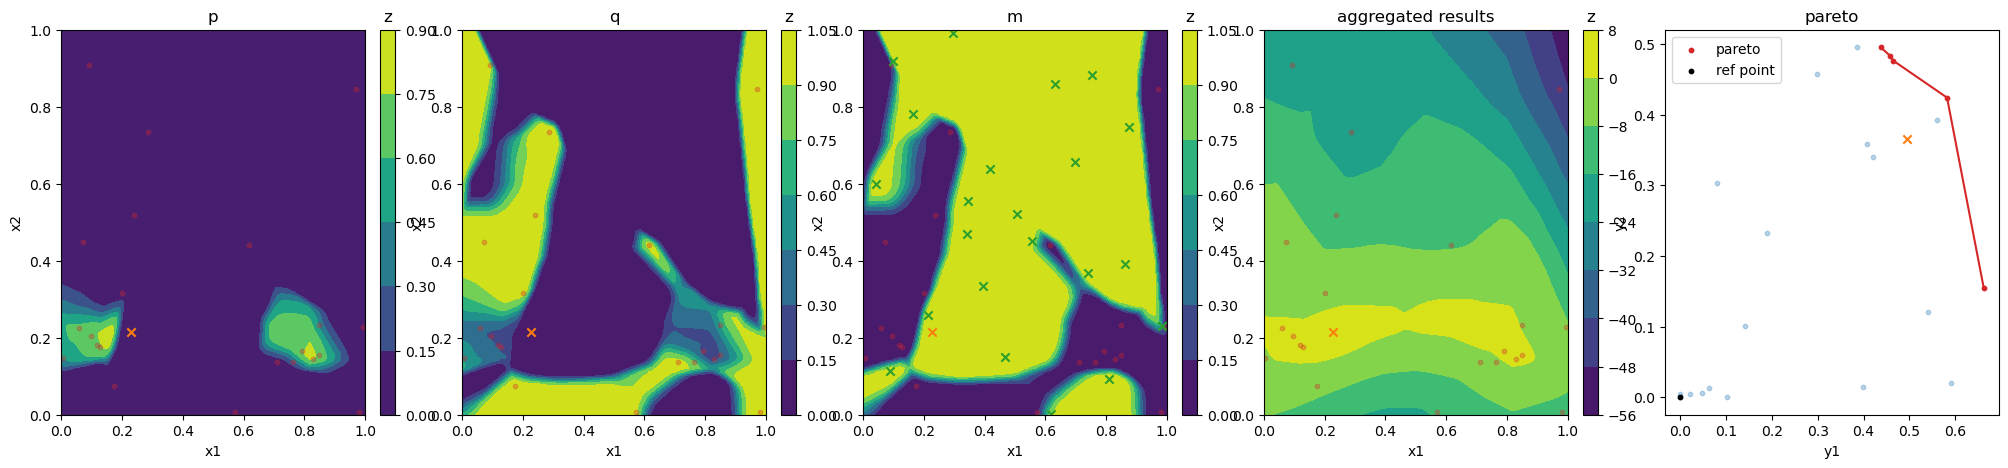

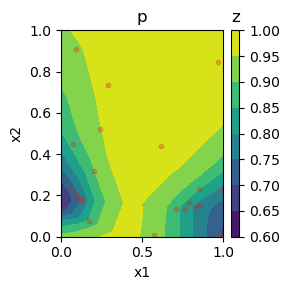

Iteration 17


100%|██████████| 500/500 [00:02<00:00, 213.26it/s]
2024-04-24 17:08:51,570 | Model fitting takes 4.52s
2024-04-24 17:08:51,574 | Optimizing the acquisition function takes 0.00s


tensor(2.8754, dtype=torch.float64)
tensor(0.9436, dtype=torch.float64)


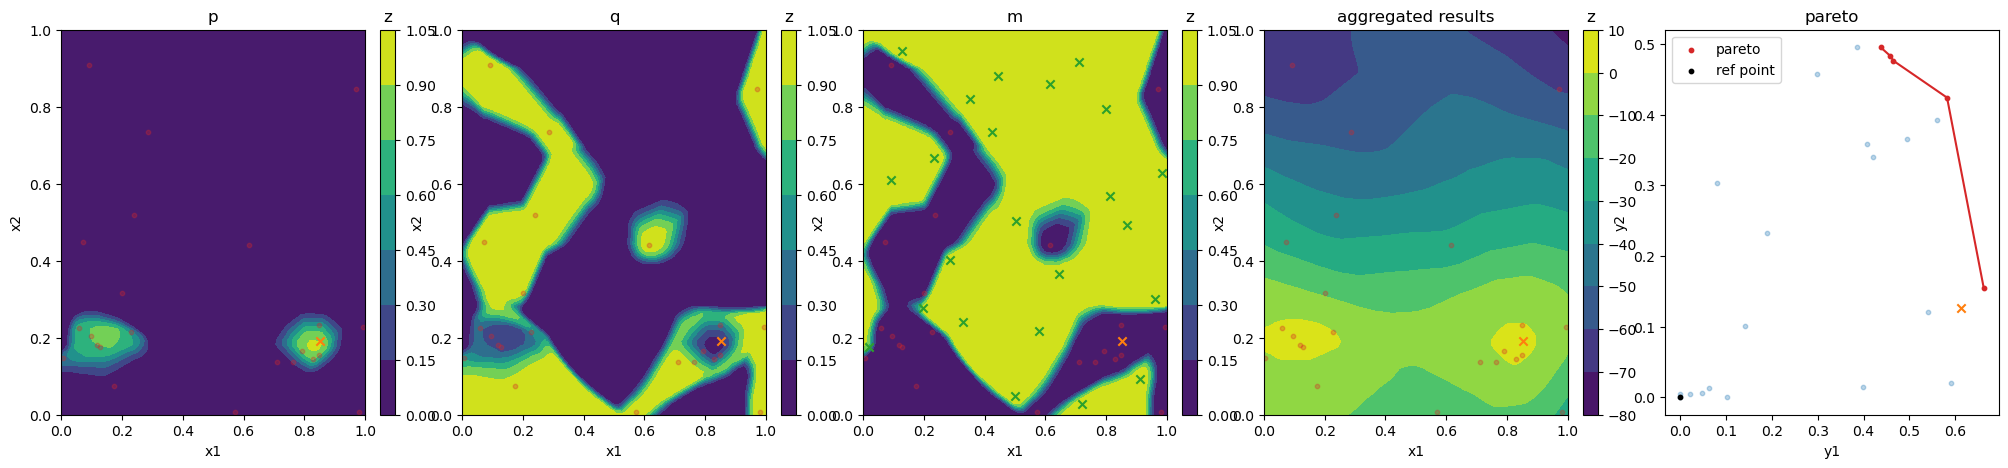

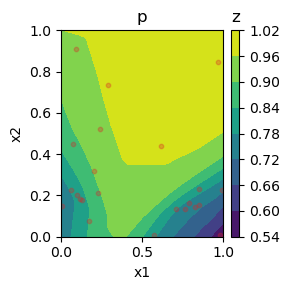

Iteration 18


100%|██████████| 500/500 [00:03<00:00, 137.82it/s]
2024-04-24 17:08:58,154 | Model fitting takes 5.57s
2024-04-24 17:08:58,160 | Optimizing the acquisition function takes 0.00s


tensor(2.8699, dtype=torch.float64)
tensor(0.9433, dtype=torch.float64)


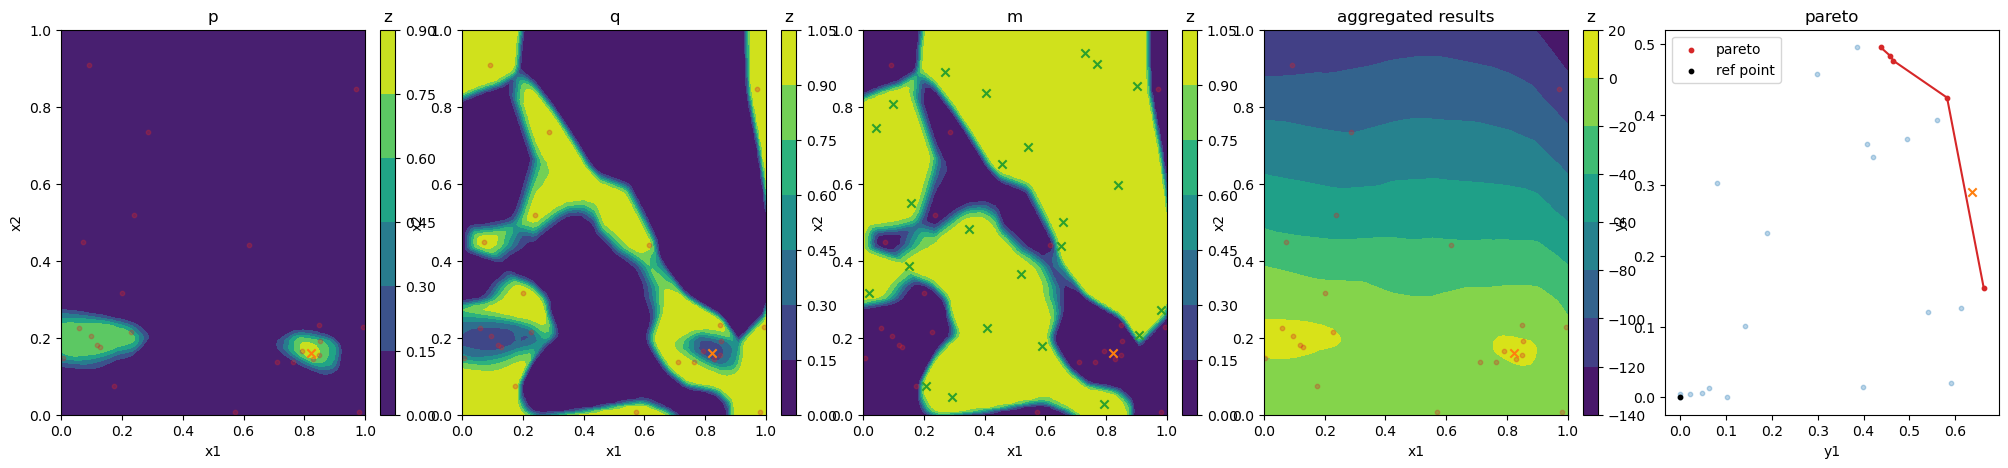

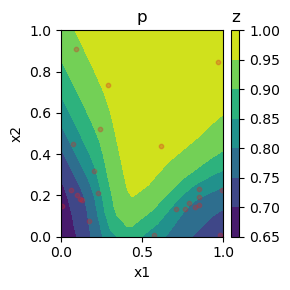

Iteration 19


100%|██████████| 500/500 [00:02<00:00, 207.86it/s]
2024-04-24 17:09:03,251 | Model fitting takes 4.24s
2024-04-24 17:09:03,255 | Optimizing the acquisition function takes 0.00s


tensor(3.0959, dtype=torch.float64)
tensor(0.9548, dtype=torch.float64)


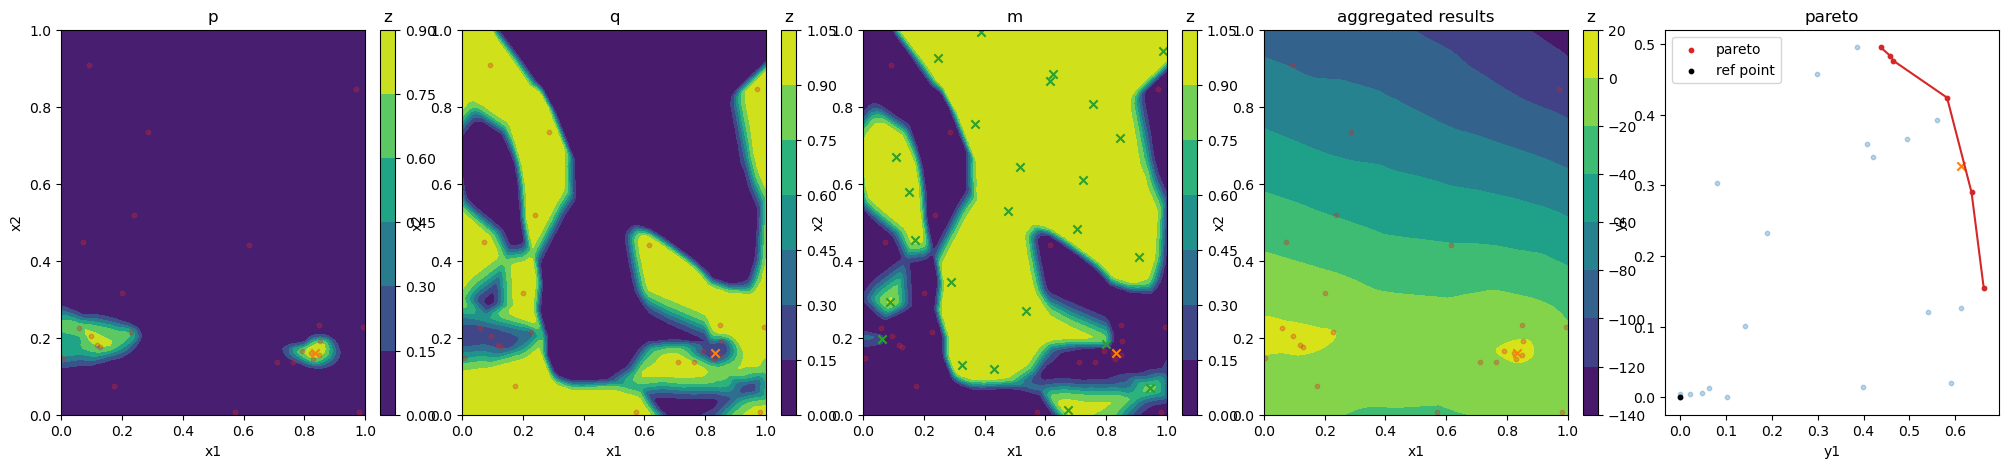

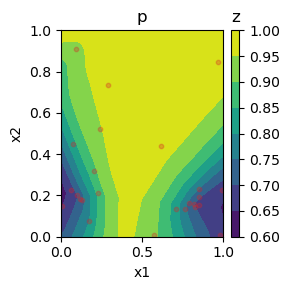

Iteration 20


100%|██████████| 500/500 [00:02<00:00, 194.39it/s]
2024-04-24 17:09:09,611 | Model fitting takes 5.28s
2024-04-24 17:09:09,616 | Optimizing the acquisition function takes 0.00s


tensor(2.8860, dtype=torch.float64)
tensor(0.9442, dtype=torch.float64)


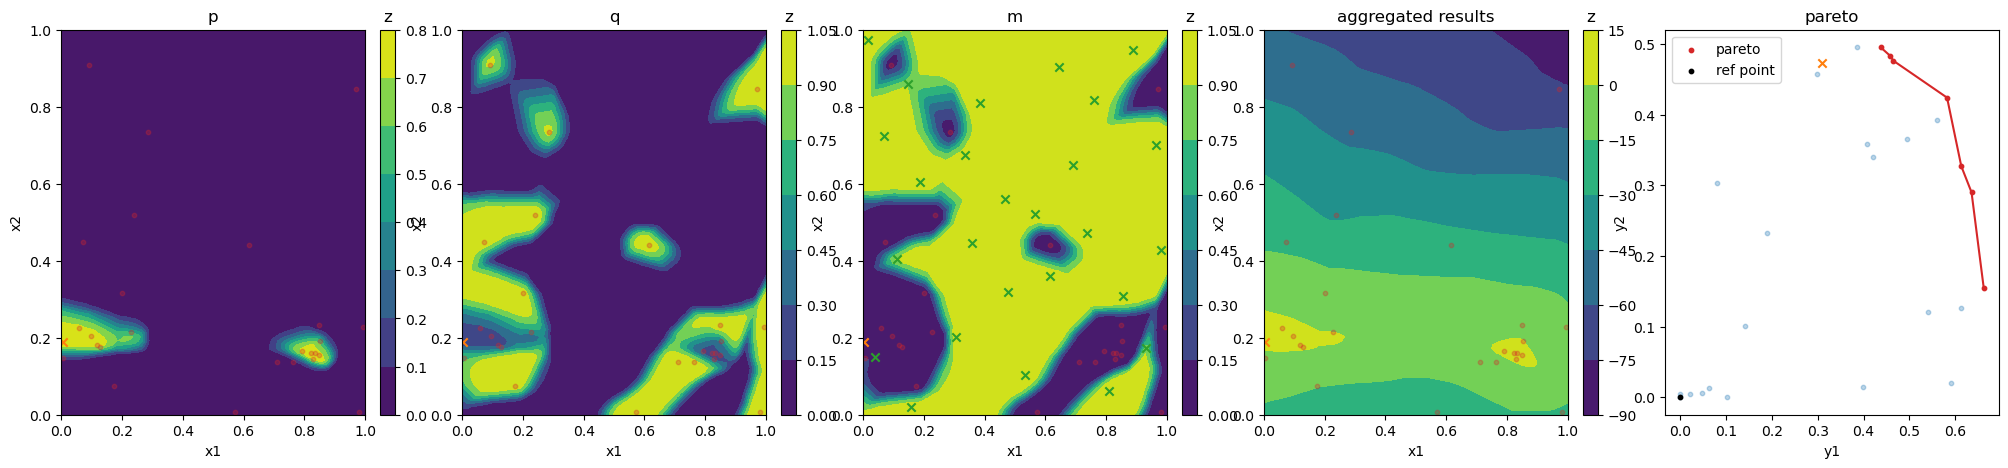

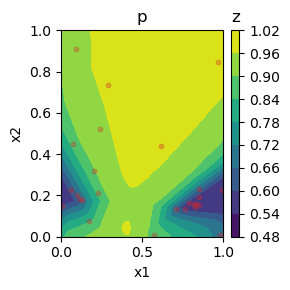

Iteration 21


100%|██████████| 500/500 [00:02<00:00, 182.27it/s]
2024-04-24 17:09:15,147 | Model fitting takes 4.55s
2024-04-24 17:09:15,151 | Optimizing the acquisition function takes 0.00s


tensor(3.4858, dtype=torch.float64)
tensor(0.9694, dtype=torch.float64)


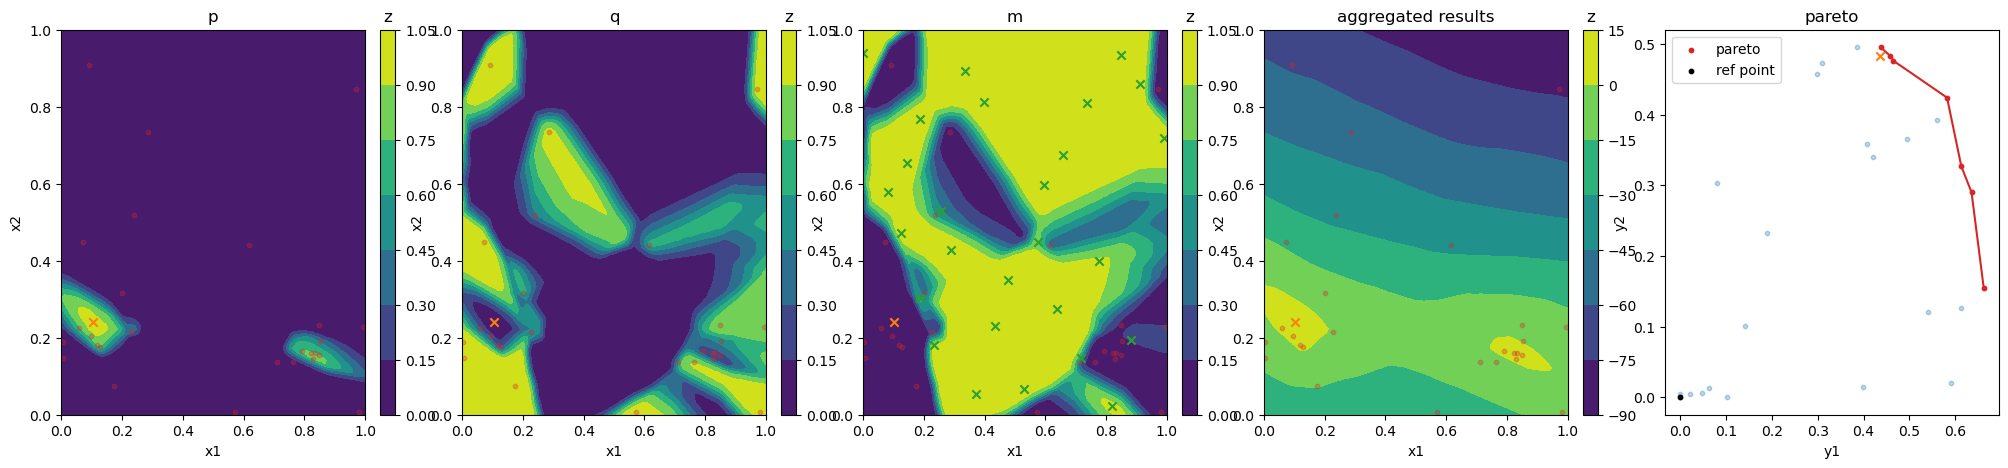

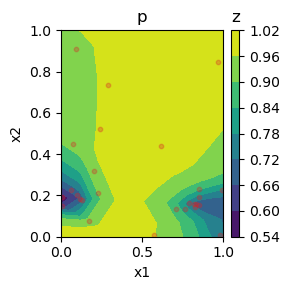

Iteration 22


100%|██████████| 500/500 [00:02<00:00, 209.56it/s]
2024-04-24 17:09:20,264 | Model fitting takes 4.28s
2024-04-24 17:09:20,270 | Optimizing the acquisition function takes 0.01s


tensor(3.7070, dtype=torch.float64)
tensor(0.9754, dtype=torch.float64)


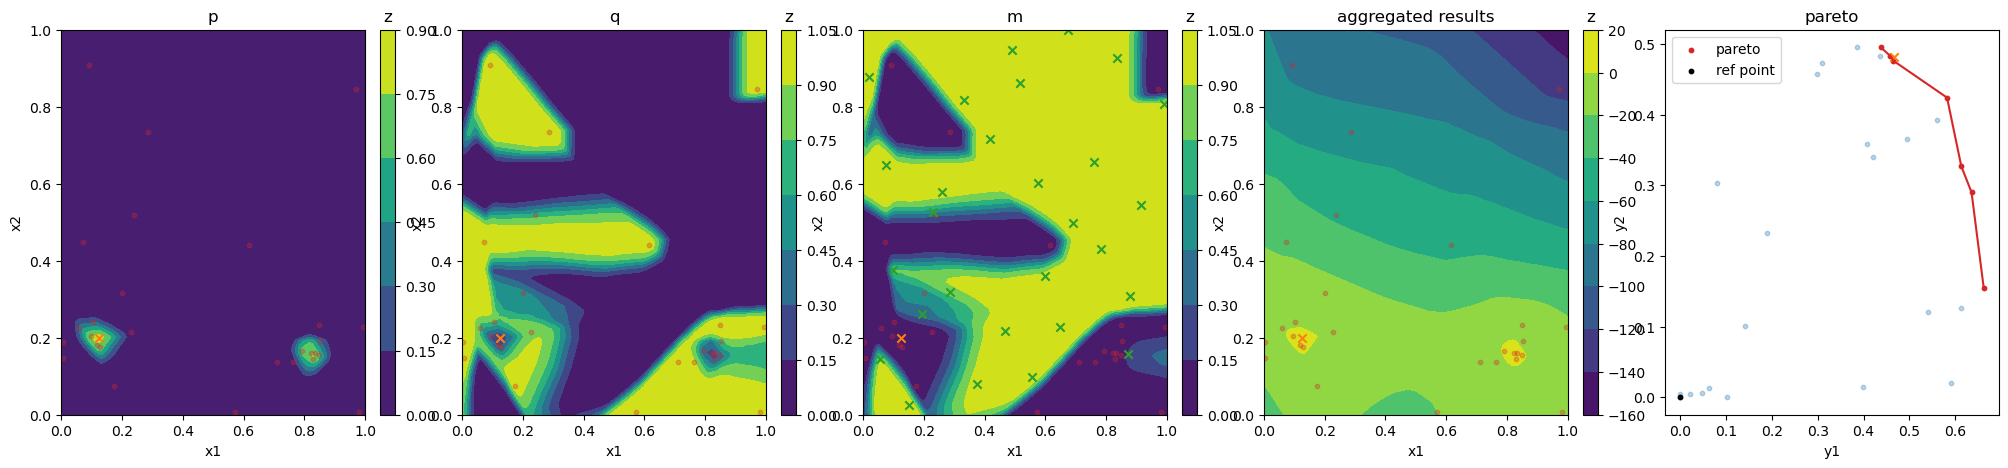

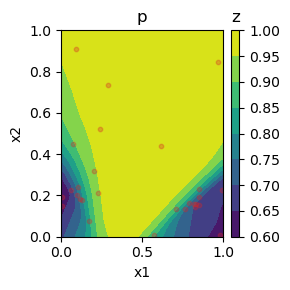

Iteration 23


100%|██████████| 500/500 [00:02<00:00, 194.59it/s]
2024-04-24 17:09:26,029 | Model fitting takes 4.65s
2024-04-24 17:09:26,034 | Optimizing the acquisition function takes 0.00s


tensor(3.4564, dtype=torch.float64)
tensor(0.9685, dtype=torch.float64)


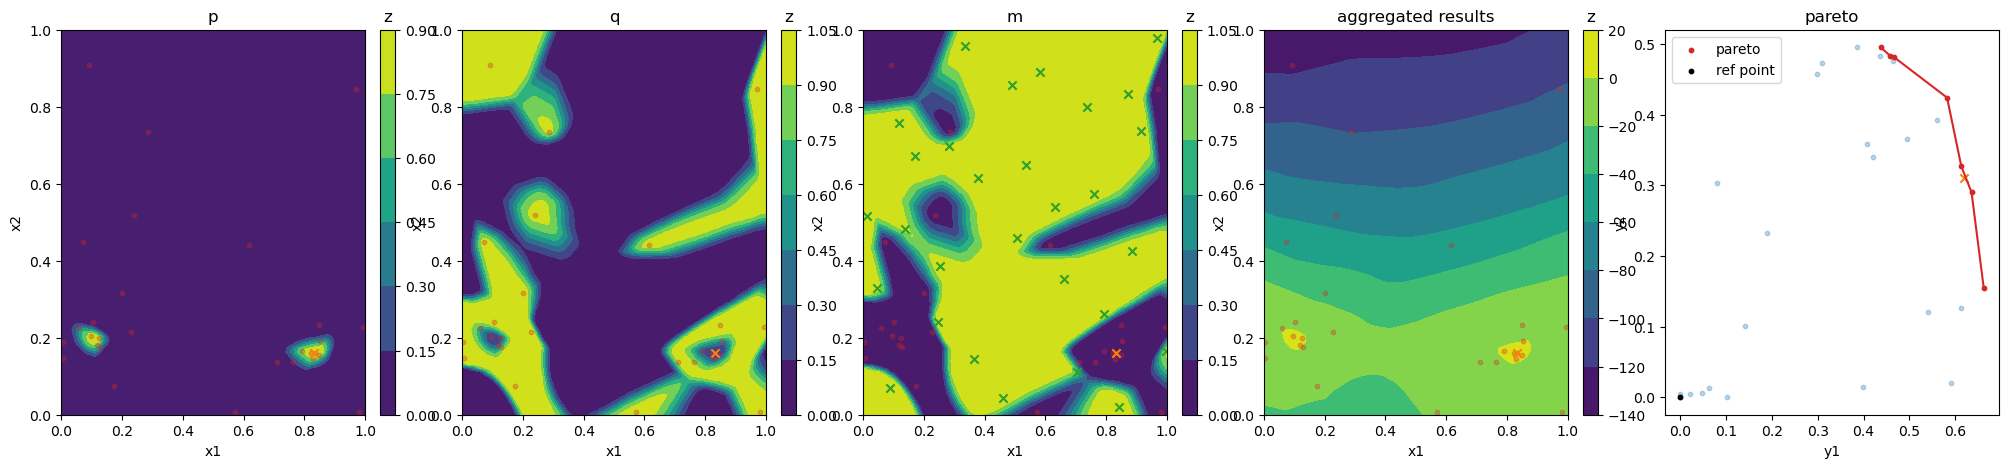

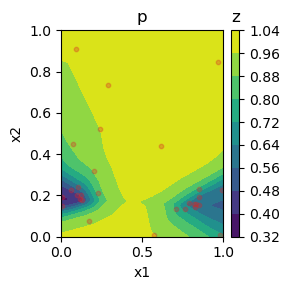

Iteration 24


100%|██████████| 500/500 [00:02<00:00, 181.23it/s]
2024-04-24 17:09:31,563 | Model fitting takes 4.68s
2024-04-24 17:09:31,568 | Optimizing the acquisition function takes 0.00s


tensor(2.9723, dtype=torch.float64)
tensor(0.9488, dtype=torch.float64)


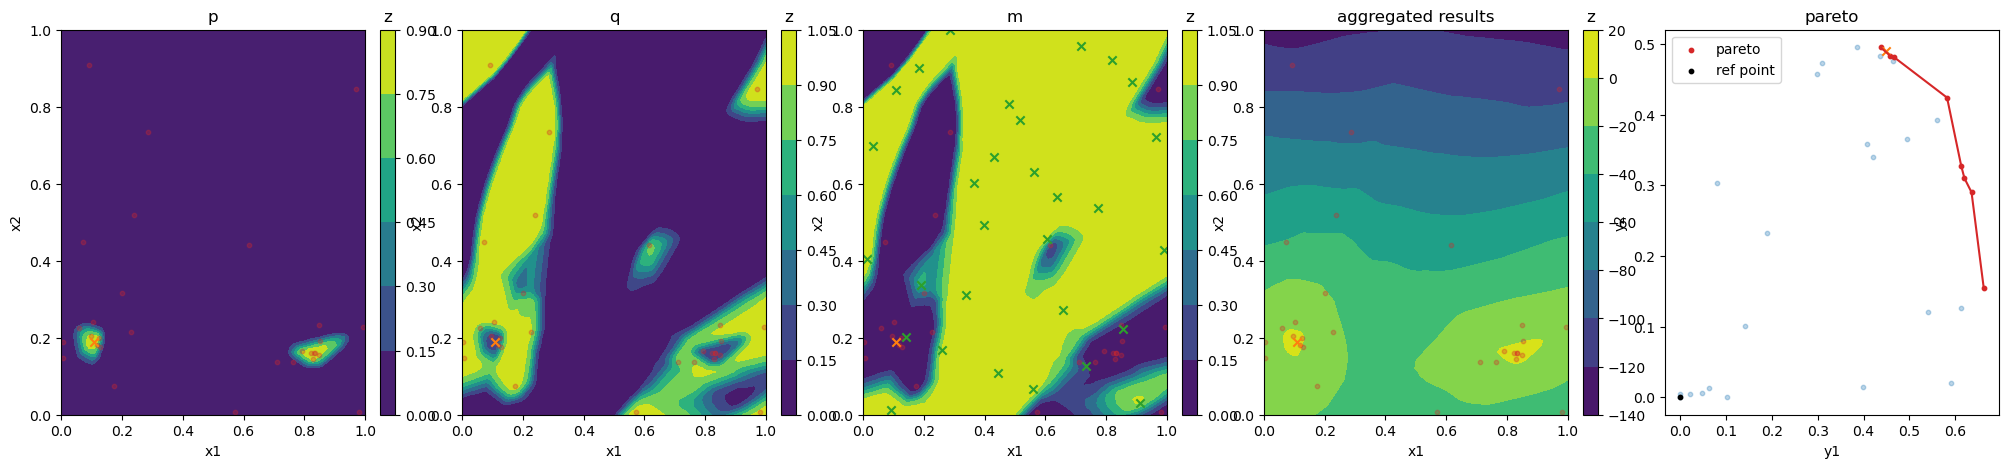

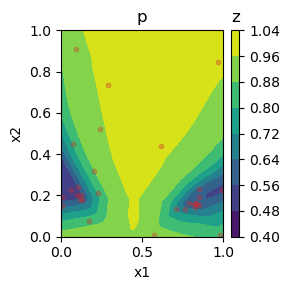

Iteration 25


100%|██████████| 500/500 [00:02<00:00, 206.99it/s]
2024-04-24 17:09:36,703 | Model fitting takes 4.30s
2024-04-24 17:09:36,708 | Optimizing the acquisition function takes 0.00s


tensor(3.0277, dtype=torch.float64)
tensor(0.9516, dtype=torch.float64)


KeyboardInterrupt: 

In [11]:
x_obs = init_x
y_obs = init_y
optimizer = MBORE_MDRE_EI_AUX(
    problem=problem, 
)
gamma =1 
for n in range(30):
    print(f"Iteration {n}")

    pareto = is_non_dominated(y_obs)
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    u, l = bd.hypercell_bounds
    u_nbd, _ = nbd.hypercell_bounds

    boxes = [Rectangle(
        l_point.cpu(),
        *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)]

    new_x = optimizer.observe_and_suggest(x_obs, y_obs, gamma=gamma)
    gamma *= 1 - (-optimizer.kl).exp()
    new_y = problem(new_x)

    preds_p = torch.empty(0, **tkwargs)
    preds_q = torch.empty(0, **tkwargs)
    preds_m = torch.empty(0, **tkwargs)
    preds = torch.empty(0, **tkwargs)
    i = 0
    with torch.no_grad():
        pred_logits = optimizer.clf(x_cands)
    acf_mdre = torch.nn.functional.softmax(pred_logits, dim=-1)
    # dr_mdre = acf_mdre[:, 0] + (1 - (-optimizer.kl).exp()) * acf_mdre[:, 2]
    dr_mdre = pred_logits[:, 0] - pred_logits[:, 1]
    # dr_mdre = pred_logits[:, 0] + pred_logits[:, 2] - pred_logits[:, 1]
    preds = torch.cat([preds, dr_mdre])
    preds_p = torch.cat([preds_p, acf_mdre[:, 0]])
    preds_q = torch.cat([preds_q, acf_mdre[:, 1]])
    preds_m = torch.cat([preds_m, acf_mdre[:, 2]])

    # plot aggregated results
    fig = plt.figure(figsize=(25, 5))

    ax_p = plt.subplot2grid((1, 5), (0, 0))
    plot_input_space(xx, yy, x_obs, preds_p, fig, ax_p, title="p")
    ax_p.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_q = plt.subplot2grid((1, 5), (0, 1))
    plot_input_space(xx, yy, x_obs, preds_q, fig, ax_q, title="q")
    ax_q.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_m = plt.subplot2grid((1, 5), (0, 2))
    plot_input_space(xx, yy, x_obs, preds_m, fig, ax_m, title="m")
    ax_m.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_m.scatter(*optimizer.x_m.t(), marker='x', color='tab:green', label='candidates')

    ax_agg = plt.subplot2grid((1, 5), (0, 3))
    plot_input_space(xx, yy, x_obs, preds, fig, ax_agg, title="aggregated results")
    ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')

    ax_agg_p = plt.subplot2grid((1,  5), (0, 4))
    plot_pareto_space(y_obs, pareto, l, u_nbd, ax_agg_p, title='pareto')
    ax_agg_p.scatter(*new_y.t(), marker='x', color='tab:orange', label='candidates')

    with torch.no_grad():
        pred_logits = optimizer.auxi_clf(x_cands)
    probs = torch.nn.functional.softmax(pred_logits, dim=-1)
    _, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_input_space(xx, yy, x_obs, probs[:, 1], fig, ax, title="p")

    plt.tight_layout()
    plt.show()
    x_obs = torch.cat([x_obs, new_x])
    y_obs = torch.cat([y_obs, new_y])